In [3]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd

In [4]:
from google.colab import files
uploaded = files.upload()

Saving RecordingData.zip to RecordingData.zip


In [5]:
zip_path = "RecordingData.zip"
extract_dir = "eye_data_unzipped"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [6]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd


# ============================================================
# 2. Basic helpers
# ============================================================
def compute_version_vergence(df):
    """
    Add version (VX, VY) and vergence (GX, GY) columns.
    VX/VY  = (LX + RX) / 2
    GX/GY  =  LX - RX
    """
    df = df.copy()
    df["VX"] = (df["LX"] + df["RX"]) / 2.0
    df["VY"] = (df["LY"] + df["RY"]) / 2.0
    df["GX"] = df["LX"] - df["RX"]
    df["GY"] = df["LY"] - df["RY"]
    return df


def detect_sampling_rate(df):
    """
    Estimate sampling rate from the T column (assumed ms).
    """
    diffs = np.diff(df["T"].values.astype(float))
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return 100.0
    mean_interval = np.mean(diffs)
    if mean_interval <= 0:
        return 100.0
    return float(np.round(1000.0 / mean_interval, 1))



In [7]:

# ============================================================
# 3. Dynamic dispersion state machine
# ============================================================
def _rms_noise(values):
    """
    RMS of (values - mean(values)).
    Used as signal noise estimate over the last 25 samples.
    """
    if len(values) < 2:
        return 0.0
    v = np.array(values, dtype=float)
    mu = v.mean()
    return float(np.sqrt(np.mean((v - mu) ** 2)))


def detect_states_dynamic(df,
                          base_threshold_deg=0.5,
                          noise_factor=2.5,
                          min_fix_dur_ms=50.0):
    """
    Dynamic dispersion threshold algorithm (paper style).

    - Uses version signal as CH (horizontal) and CV (vertical).
    - Instantaneous "state" internally:
        * 'stable'  -> eventually becomes fixation/transient
        * 'moving'  -> becomes saccade
        * 'distortion' -> missing signal
    - A stable segment is labeled:
        * fixation  if duration >= min_fix_dur_ms
        * transient otherwise
    - A moving segment is labeled saccade.
    - Distortion segments remain distortion.
    """
    n = len(df)
    if n == 0:
        return []

    # CH / CV = version
    CH = ((df["LX"] + df["RX"]) / 2.0).values.astype(float)
    CV = ((df["LY"] + df["RY"]) / 2.0).values.astype(float)
    T = df["T"].values.astype(float)

    # approximate dt from median diff
    diffs = np.diff(T)
    diffs = diffs[diffs > 0]
    dt_ms = np.median(diffs) if len(diffs) > 0 else 10.0
    min_fix_samples = max(1, int(np.ceil(min_fix_dur_ms / dt_ms)))

    events = []

    current_state = None          # 'stable', 'moving', 'distortion'
    state_start = 0
    state_CH = []
    state_CV = []
    tail_CH = []
    tail_CV = []

    def close_state(end_idx):
        nonlocal current_state, state_start, state_CH, state_CV, tail_CH, tail_CV
        if current_state is None:
            return
        start_idx = state_start
        if end_idx < start_idx:
            return

        start_time = T[start_idx]
        end_time = T[end_idx]
        duration = end_time - start_time

        # label according to the paper rules
        if current_state == "distortion":
            label = "distortion"
        elif current_state == "stable":
            if (end_idx - start_idx + 1) >= min_fix_samples:
                label = "fixation"
            else:
                label = "transient"
        elif current_state == "moving":
            label = "saccade"
        else:
            label = "transient"

        events.append({
            "state": label,
            "start_idx": start_idx,
            "end_idx": end_idx,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
        })

        # reset state buffers
        current_state = None
        state_start = end_idx + 1
        state_CH = []
        state_CV = []
        tail_CH = []
        tail_CV = []

    for i in range(n):
        lx = df["LX"].iloc[i]
        rx = df["RX"].iloc[i]
        ly = df["LY"].iloc[i]
        ry = df["RY"].iloc[i]

        # 1) Distortion: any signal missing
        if np.isnan(lx) or np.isnan(rx) or np.isnan(ly) or np.isnan(ry):
            new_state = "distortion"
            if current_state is not None and current_state != new_state:
                close_state(i - 1)
            if current_state is None:
                current_state = new_state
                state_start = i
            continue

        x = CH[i]
        y = CV[i]

        # update buffers
        tail_CH.append(x)
        tail_CV.append(y)
        state_CH.append(x)
        state_CV.append(y)

        if len(tail_CH) > 25:
            tail_CH.pop(0)
            tail_CV.pop(0)

        # dynamic threshold = 0.5 deg + 2.5 * RMS noise
        noise_x = _rms_noise(tail_CH)
        noise_y = _rms_noise(tail_CV)
        threshold = base_threshold_deg + noise_factor * max(noise_x, noise_y)

        # distance from current state's mean
        if len(state_CH) > 0:
            mu_x = float(np.mean(state_CH))
            mu_y = float(np.mean(state_CV))
            dist = np.sqrt((x - mu_x) ** 2 + (y - mu_y) ** 2)
        else:
            dist = 0.0

        stable = dist <= threshold
        new_state = "stable" if stable else "moving"

        if current_state is None:
            current_state = new_state
            state_start = i
        elif current_state in ["stable", "moving"]:
            if new_state != current_state:
                # state change: close previous segment
                close_state(i - 1)
                current_state = new_state
                state_start = i
                state_CH = [x]
                state_CV = [y]
        elif current_state == "distortion":
            if new_state != "distortion":
                close_state(i - 1)
                current_state = new_state
                state_start = i
                state_CH = [x]
                state_CV = [y]

    # close last state
    close_state(n - 1)

    return events


In [8]:
# ============================================================
# 4. From states → fixations + saccades with direction
# ============================================================
def label_fixations_saccades(events, df):
    """
    - Keep only fixation and saccade events.
    - For saccades: direction = progressive (ΔVX > 0) or regressive (ΔVX <= 0).
    - For fixations: direction = direction of preceding saccade
      (as described in the paper).
    """
    VX = ((df["LX"] + df["RX"]) / 2.0).values.astype(float)

    # step 1: give directions to saccades
    for ev in events:
        if ev["state"] == "saccade":
            s = ev["start_idx"]
            e = ev["end_idx"]
            if e <= s:
                ev["direction"] = "unknown"
            else:
                delta = VX[e] - VX[s]
                ev["direction"] = "progressive" if delta > 0 else "regressive"
        else:
            ev["direction"] = "unknown"

    # step 2: propagate direction to following fixations
    last_dir = "unknown"
    for ev in events:
        if ev["state"] == "saccade":
            last_dir = ev["direction"]
        elif ev["state"] == "fixation":
            ev["direction"] = last_dir

    # keep only fixations & saccades
    fs = [ev for ev in events if ev["state"] in ["fixation", "saccade"]]
    return fs


In [9]:
# ============================================================
# 5. Per-event feature computation
# ============================================================
def compute_single_event_features(df, ev):
    """
    Paper's 6 parameter types, each measured for version x/y and vergence x/y:

        (1) duration
        (2) distance spanning the event        → version_x/y_distance, vergence_x/y_distance
        (3) average eye position               → version_x/y_mean,     vergence_x/y_mean
        (4) std of position                    → version_x/y_std,      vergence_x/y_std
        (5) max range between any two positions → version_x/y_range,    vergence_x/y_range
        (6) accumulated distance               → version_x/y_accum,    vergence_x/y_accum

    Total: 1 + (5 × 4) = 21 parameters per event
    """
    s, e = ev["start_idx"], ev["end_idx"]
    seg  = df.iloc[s:e+1]

    VX = seg["VX"].values.astype(float)
    VY = seg["VY"].values.astype(float)
    GX = seg["GX"].values.astype(float)
    GY = seg["GY"].values.astype(float)

    def accum(arr):
        """Sum of absolute differences (1D path length)."""
        return float(np.sum(np.abs(np.diff(arr)))) if len(arr) > 1 else 0.0

    return {
        "event_type": ev["state"],
        "direction":  ev["direction"],

        # (1) duration
        "duration":                  float(ev["duration"]),

        # (2) distance spanning the event (end - start, signed)
        "version_x_distance":       float(VX[-1] - VX[0]),
        "version_y_distance":       float(VY[-1] - VY[0]),
        "vergence_x_distance":      float(GX[-1] - GX[0]),
        "vergence_y_distance":      float(GY[-1] - GY[0]),

        # (3) average position
        "version_x_mean":           float(VX.mean()),
        "version_y_mean":           float(VY.mean()),
        "vergence_x_mean":          float(GX.mean()),
        "vergence_y_mean":          float(GY.mean()),

        # (4) std of position
        "version_x_std":            float(VX.std(ddof=0)),
        "version_y_std":            float(VY.std(ddof=0)),
        "vergence_x_std":           float(GX.std(ddof=0)),
        "vergence_y_std":           float(GY.std(ddof=0)),

        # (5) max range (max - min)
        "version_x_range":          float(VX.max() - VX.min()),
        "version_y_range":          float(VY.max() - VY.min()),
        "vergence_x_range":         float(GX.max() - GX.min()),
        "vergence_y_range":         float(GY.max() - GY.min()),

        # (6) accumulated distance (1D path length per axis)
        "version_x_accum":          accum(VX),
        "version_y_accum":          accum(VY),
        "vergence_x_accum":         accum(GX),
        "vergence_y_accum":         accum(GY),
    }


def build_event_dataframe(df, events_fs):
    """Turn fixation/saccade event list into a per-event DataFrame."""
    rows = [compute_single_event_features(df, ev) for ev in events_fs]
    if len(rows) == 0:
        return pd.DataFrame()
    return pd.DataFrame(rows)


In [10]:
# ============================================================
# 6. Summarize to exactly 168 features (subject-level)
# ============================================================
def summarize_168_features(events_df):
    """
    4 event types × 21 parameters × 2 stats (mean, std) = 168 features

    Event types:
        fix_prog  : fixations after progressive saccades
        fix_reg   : fixations after regressive saccades
        sac_prog  : progressive saccades
        sac_reg   : regressive saccades

    21 parameters per event:
        duration (1)
        + distance, mean, std, range, accum × version x/y & vergence x/y (5 × 4 = 20)
    """
    summary = {}

    groups = {
        "fix_prog": (events_df["event_type"] == "fixation") & (events_df["direction"] == "progressive"),
        "fix_reg":  (events_df["event_type"] == "fixation") & (events_df["direction"] == "regressive"),
        "sac_prog": (events_df["event_type"] == "saccade")  & (events_df["direction"] == "progressive"),
        "sac_reg":  (events_df["event_type"] == "saccade")  & (events_df["direction"] == "regressive"),
    }

    # 21 parameters — must match keys in compute_single_event_features
    feature_cols = [
        "duration",
        "version_x_distance",  "version_y_distance",  "vergence_x_distance",  "vergence_y_distance",
        "version_x_mean",      "version_y_mean",      "vergence_x_mean",      "vergence_y_mean",
        "version_x_std",       "version_y_std",       "vergence_x_std",       "vergence_y_std",
        "version_x_range",     "version_y_range",     "vergence_x_range",     "vergence_y_range",
        "version_x_accum",     "version_y_accum",     "vergence_x_accum",     "vergence_y_accum",
    ]

    for gname, mask in groups.items():
        g = events_df[mask]

        if len(g) == 0:
            for col in feature_cols:
                summary[f"{gname}_{col}_mean"] = 0.0
                summary[f"{gname}_{col}_std"]  = 0.0
        else:
            for col in feature_cols:
                vals = g[col].values.astype(float)
                summary[f"{gname}_{col}_mean"] = float(np.mean(vals))
                summary[f"{gname}_{col}_std"]  = float(np.std(vals, ddof=0))

    return pd.Series(summary)


In [11]:
all_features = []

for file in glob.glob(os.path.join(extract_dir, "**/*.txt"), recursive=True):
    base = os.path.basename(file)
    if base.lower().startswith("info"):
        continue  # skip meta files

    try:
        df = pd.read_csv(file, sep="\t", decimal=",", engine="python")
    except Exception as e:
        print(f"Failed to read {file}: {e}")
        continue

    # Required columns
    required_cols = {"T", "LX", "LY", "RX", "RY"}
    if not required_cols.issubset(df.columns):
        print(f"⚠️ Skipping {file} — missing required columns.")
        continue

    # Ensure numeric
    for c in required_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Sort by time
    df = df.sort_values("T").reset_index(drop=True)

    # Compute version/vergence
    df = compute_version_vergence(df)

    # Sampling rate
    sampling_rate = detect_sampling_rate(df)

    # Detect fixations/saccades
    states = detect_states_dynamic(df)
    fs_events = label_fixations_saccades(states, df)

    # Compute per-event features including vergence spans/distances
    events_df = build_event_dataframe(df, fs_events)
    if len(events_df) == 0:
        print(f"⚠️ No events found in {file}. Skipping.")
        continue

    # Summarize to 168 subject-level features
    feat = summarize_168_features(events_df)

    # Add metadata
    feat["file"] = file
    feat["sampling_rate"] = sampling_rate
    feat["n_fixations"] = int((events_df["event_type"] == "fixation").sum())
    feat["n_saccades"]  = int((events_df["event_type"] == "saccade").sum())

    all_features.append(feat)
    print(f"Processed {file}: fix={feat['n_fixations']}, sac={feat['n_saccades']}")

# Save all features to CSV
if len(all_features) > 0:
    all_df = pd.DataFrame(all_features)
    all_df.to_csv("eye_features_168.csv", index=False)
    print("\n✅ DONE. Saved → eye_features_168.csv")
else:
    print("\n⚠️ No valid files processed.")


⚠️ Skipping eye_data_unzipped/Recording Data/Subject codes.txt — missing required columns.
Processed eye_data_unzipped/Recording Data/343BJ3/A1R.txt: fix=48, sac=116
Processed eye_data_unzipped/Recording Data/755TD3/A1R.txt: fix=58, sac=203
Processed eye_data_unzipped/Recording Data/795JM1/A1R.txt: fix=63, sac=204
Processed eye_data_unzipped/Recording Data/796NT3/A1R.txt: fix=51, sac=143
Processed eye_data_unzipped/Recording Data/342GD1/A1R.txt: fix=82, sac=107
Processed eye_data_unzipped/Recording Data/132AD3/A1R.txt: fix=67, sac=169
Processed eye_data_unzipped/Recording Data/752NA1/A1R.txt: fix=71, sac=73
Processed eye_data_unzipped/Recording Data/725MF1/A1R.txt: fix=77, sac=103
Processed eye_data_unzipped/Recording Data/322RE1/A1R.txt: fix=67, sac=184
Processed eye_data_unzipped/Recording Data/794GO3/A1R.txt: fix=51, sac=125
Processed eye_data_unzipped/Recording Data/781PT1/A1R.txt: fix=78, sac=111
Processed eye_data_unzipped/Recording Data/346KU1/A1R.txt: fix=70, sac=199
Processed 

In [12]:
import pandas as pd

df = pd.read_csv("eye_features_168.csv")

print("Nulls in file column:", df["file"].isna().sum())
print("Example values:")
print(df["file"].head(20).tolist())

# Find the bad ones (no slash and no backslash)
bad = df[df["file"].astype(str).apply(lambda s: ("/" not in s) and ("\\" not in s))]
print("Bad rows count:", len(bad))
print(bad["file"].head(20).tolist())


Nulls in file column: 0
Example values:
['eye_data_unzipped/Recording Data/343BJ3/A1R.txt', 'eye_data_unzipped/Recording Data/755TD3/A1R.txt', 'eye_data_unzipped/Recording Data/795JM1/A1R.txt', 'eye_data_unzipped/Recording Data/796NT3/A1R.txt', 'eye_data_unzipped/Recording Data/342GD1/A1R.txt', 'eye_data_unzipped/Recording Data/132AD3/A1R.txt', 'eye_data_unzipped/Recording Data/752NA1/A1R.txt', 'eye_data_unzipped/Recording Data/725MF1/A1R.txt', 'eye_data_unzipped/Recording Data/322RE1/A1R.txt', 'eye_data_unzipped/Recording Data/794GO3/A1R.txt', 'eye_data_unzipped/Recording Data/781PT1/A1R.txt', 'eye_data_unzipped/Recording Data/346KU1/A1R.txt', 'eye_data_unzipped/Recording Data/781SD3/A1R.txt', 'eye_data_unzipped/Recording Data/724OP3/A1R.txt', 'eye_data_unzipped/Recording Data/772AK3/A1R.txt', 'eye_data_unzipped/Recording Data/142EJ1/A1R.txt', 'eye_data_unzipped/Recording Data/794LA3/A1R.txt', 'eye_data_unzipped/Recording Data/723SJ1/A1R.txt', 'eye_data_unzipped/Recording Data/726OG1/

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv("eye_features_168.csv")

def get_subject_code(file_path):
    # normalize Windows \ to /
    s = str(file_path).replace("\\", "/")
    folder_name = s.split("/")[-2]      # e.g. "111GM3"
    return int(folder_name[-1])         # -> 3

df["subject_code"] = df["file"].apply(get_subject_code)

print(df[["file", "subject_code"]].head())
print(df["subject_code"].value_counts())


# Apply function to create 'subject_code' column
df['subject_code'] = df['file'].apply(get_subject_code)

# Function to assign risk group
def assign_risk(code):
    if code in [1, 2]:
        return 'High Risk'
    elif code in [3, 4]:
        return 'Low Risk'
    else:
        return 'Unknown'

# Function to assign gender
def assign_gender(code):
    if code in [1, 3]:
        return 'Male'
    elif code in [2, 4]:
        return 'Female'
    else:
        return 'Unknown'

# Apply functions to create 'risk_group' and 'gender' columns
df['risk_group'] = df['subject_code'].apply(assign_risk)
df['gender'] = df['subject_code'].apply(assign_gender)

# Convert categorical to numeric for machine learning
df['risk_group_label'] = df['risk_group'].map({'High Risk': 1, 'Low Risk': 0})
df['gender_label'] = df['gender'].map({'Male': 1, 'Female': 0})

# Save updated DataFrame to a new CSV
df.to_csv("eye_features_with_labels.csv", index=False)

print("Columns added and CSV saved successfully!")
print(df[['file','subject_code','risk_group','gender','risk_group_label','gender_label']].head())
print(df['risk_group'].value_counts(dropna=False))
print(df[df['risk_group'].isin(['Unknown'])][['file','subject_code']].head(10))


                                              file  subject_code
0  eye_data_unzipped/Recording Data/343BJ3/A1R.txt             3
1  eye_data_unzipped/Recording Data/755TD3/A1R.txt             3
2  eye_data_unzipped/Recording Data/795JM1/A1R.txt             1
3  eye_data_unzipped/Recording Data/796NT3/A1R.txt             3
4  eye_data_unzipped/Recording Data/342GD1/A1R.txt             1
subject_code
1    76
3    69
2    21
4    19
Name: count, dtype: int64
Columns added and CSV saved successfully!
                                              file  subject_code risk_group  \
0  eye_data_unzipped/Recording Data/343BJ3/A1R.txt             3   Low Risk   
1  eye_data_unzipped/Recording Data/755TD3/A1R.txt             3   Low Risk   
2  eye_data_unzipped/Recording Data/795JM1/A1R.txt             1  High Risk   
3  eye_data_unzipped/Recording Data/796NT3/A1R.txt             3   Low Risk   
4  eye_data_unzipped/Recording Data/342GD1/A1R.txt             1  High Risk   

  gender  risk_group_l

In [14]:
df = pd.read_csv("eye_features_with_labels.csv")
print(df['risk_group'].value_counts(dropna=False))
print(df['gender'].value_counts(dropna=False))
print("Unknown rows:", (df['risk_group']=="Unknown").sum(), (df['gender']=="Unknown").sum())


risk_group
High Risk    97
Low Risk     88
Name: count, dtype: int64
gender
Male      145
Female     40
Name: count, dtype: int64
Unknown rows: 0 0


In [15]:
import pandas as pd

df = pd.read_csv("eye_features_with_labels.csv")  # change filename if needed

print("Total columns:", len(df.columns))
for i, col in enumerate(df.columns):
    print(i, col)


Total columns: 177
0 fix_prog_duration_mean
1 fix_prog_duration_std
2 fix_prog_version_x_distance_mean
3 fix_prog_version_x_distance_std
4 fix_prog_version_y_distance_mean
5 fix_prog_version_y_distance_std
6 fix_prog_vergence_x_distance_mean
7 fix_prog_vergence_x_distance_std
8 fix_prog_vergence_y_distance_mean
9 fix_prog_vergence_y_distance_std
10 fix_prog_version_x_mean_mean
11 fix_prog_version_x_mean_std
12 fix_prog_version_y_mean_mean
13 fix_prog_version_y_mean_std
14 fix_prog_vergence_x_mean_mean
15 fix_prog_vergence_x_mean_std
16 fix_prog_vergence_y_mean_mean
17 fix_prog_vergence_y_mean_std
18 fix_prog_version_x_std_mean
19 fix_prog_version_x_std_std
20 fix_prog_version_y_std_mean
21 fix_prog_version_y_std_std
22 fix_prog_vergence_x_std_mean
23 fix_prog_vergence_x_std_std
24 fix_prog_vergence_y_std_mean
25 fix_prog_vergence_y_std_std
26 fix_prog_version_x_range_mean
27 fix_prog_version_x_range_std
28 fix_prog_version_y_range_mean
29 fix_prog_version_y_range_std
30 fix_prog_vergen

In [24]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_recall_fscore_support, roc_auc_score, roc_curve)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("eye_features_with_labels.csv")

# Select features and target
EXCLUDE_COLS = {"file","risk_group","gender","risk_group_label","gender_label","subject_code"}
META_FEATURES = {"sampling_rate","n_fixations","n_saccades"}

feature_cols = [c for c in df.columns if c not in EXCLUDE_COLS and c not in META_FEATURES]
X = df[feature_cols].astype(float).values
y = df["risk_group_label"].astype(int).values

print(f"Dataset: {len(X)} subjects, {X.shape[1]} features")
print(f"Class distribution: {np.bincount(y)}")

# Parameters
n_splits = 10
n_repeats = 10
random_seed = 42  # Fixed seed for reproducibility

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Store results
all_accuracies = []
all_sensitivities = []
all_specificities = []
all_auc_scores = []

# Per-class metrics
all_precisions_hr = []
all_precisions_lr = []
all_recalls_hr = []
all_recalls_lr = []
all_f1_hr = []
all_f1_lr = []

# Macro/Weighted averages
all_precisions_macro = []
all_precisions_weighted = []
all_recalls_macro = []
all_recalls_weighted = []
all_f1_macro = []
all_f1_weighted = []

# For confusion matrices
all_fold_cms = []
all_true_labels = []
all_pred_labels = []
all_pred_probas = []

# For feature importance
all_feature_importances = []

# For best parameters tracking
all_best_params = []

# For ROC curves
all_fpr = []
all_tpr = []

last_repeat_true = []
last_repeat_pred = []
last_repeat_proba = []

total_iterations = n_splits * n_repeats
current_iteration = 0

print(f"\nStarting {n_repeats} × {n_splits}-fold CV with XGBoost + GridSearch...")
print(f"Random seed: {random_seed}")
print(f"Total grid search combinations: {np.prod([len(v) for v in xgb_param_grid.values()])}")
print()

for repeat in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed + repeat)

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        current_iteration += 1
        if current_iteration % 10 == 0:
            print(f"Progress: {current_iteration}/{total_iterations} folds ({100*current_iteration/total_iterations:.1f}%)")

        X_train_raw, X_test_raw = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Standardize features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_raw)
        X_test = scaler.transform(X_test_raw)

        # GridSearchCV inside the fold
        xgb = XGBClassifier(
            random_state=random_seed,
            n_jobs=-1,
            eval_metric='logloss'
        )
        grid_search = GridSearchCV(
            xgb,
            xgb_param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_xgb = grid_search.best_estimator_

        # Track best parameters
        all_best_params.append(grid_search.best_params_)

        # Store feature importances from this fold
        all_feature_importances.append(best_xgb.feature_importances_)

        # Test on the outer fold
        y_pred = best_xgb.predict(X_test)
        y_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probability for class 1

        acc = accuracy_score(y_test, y_pred)
        all_accuracies.append(acc)

        # Calculate AUC and ROC curve
        try:
            auc_score = roc_auc_score(y_test, y_proba)
            all_auc_scores.append(auc_score)

            # Calculate ROC curve for this fold
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
        except:
            pass  # In case of issues with single-class folds

        # Calculate confusion matrix for this fold
        cm = confusion_matrix(y_test, y_pred)
        all_fold_cms.append(cm)
        tn, fp, fn, tp = cm.ravel()

        # Store for aggregated confusion matrix
        all_true_labels.extend(y_test)
        all_pred_labels.extend(y_pred)
        all_pred_probas.extend(y_proba)

        # Sensitivity and Specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)

        # Per-class metrics (average=None)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average=None, zero_division=0
        )
        all_precisions_hr.append(precision[0])
        all_precisions_lr.append(precision[1])
        all_recalls_hr.append(recall[0])
        all_recalls_lr.append(recall[1])
        all_f1_hr.append(f1[0])
        all_f1_lr.append(f1[1])

        # Macro average metrics
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_test, y_pred, average='macro', zero_division=0
        )
        all_precisions_macro.append(precision_macro)
        all_recalls_macro.append(recall_macro)
        all_f1_macro.append(f1_macro)

        # Weighted average metrics
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        all_precisions_weighted.append(precision_weighted)
        all_recalls_weighted.append(recall_weighted)
        all_f1_weighted.append(f1_weighted)

        # Store last repeat predictions
        if repeat == n_repeats - 1:
            last_repeat_true.extend(y_test)
            last_repeat_pred.extend(y_pred)
            last_repeat_proba.extend(y_proba)

print("\n✓ Cross-validation completed!")

# Library versions for reproducibility
import sklearn
import xgboost as xgb_lib
print(f"\n📚 Library versions:")
print(f"  scikit-learn: {sklearn.__version__}")
print(f"  xgboost: {xgb_lib.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")

Dataset: 185 subjects, 168 features
Class distribution: [88 97]

Starting 10 × 10-fold CV with XGBoost + GridSearch...
Random seed: 42
Total grid search combinations: 96

Progress: 10/100 folds (10.0%)
Progress: 20/100 folds (20.0%)
Progress: 30/100 folds (30.0%)
Progress: 40/100 folds (40.0%)
Progress: 50/100 folds (50.0%)
Progress: 60/100 folds (60.0%)
Progress: 70/100 folds (70.0%)
Progress: 80/100 folds (80.0%)
Progress: 90/100 folds (90.0%)
Progress: 100/100 folds (100.0%)

✓ Cross-validation completed!

📚 Library versions:
  scikit-learn: 1.6.1
  xgboost: 3.1.3
  numpy: 2.0.2
  pandas: 2.2.2


In [25]:
# ============================================================
# RESULTS SECTION
# ============================================================

print("="*70)
print("CROSS-VALIDATION RESULTS: XGBoost with GridSearch")
print("="*70)

# ============================================================
# Best Hyperparameters Analysis
# ============================================================
print("\n" + "="*70)
print("BEST HYPERPARAMETERS (from GridSearchCV)")
print("="*70)

# Count frequency of each parameter configuration
param_counter = Counter([frozenset(d.items()) for d in all_best_params])
most_common_params = dict(param_counter.most_common(1)[0][0])

print(f"\nMost frequently selected parameters ({param_counter.most_common(1)[0][1]}/{len(all_best_params)} folds):")
for param, value in most_common_params.items():
    print(f"  {param:<20}: {value}")

print(f"\nParameter variation across folds:")
for param in xgb_param_grid.keys():
    values = [d[param] for d in all_best_params]
    unique_values = set(values)
    if len(unique_values) > 1:
        print(f"  {param:<20}: {dict(Counter(values))}")
    else:
        print(f"  {param:<20}: {list(unique_values)[0]} (consistent)")

# ============================================================
# Overall Performance Metrics
# ============================================================
mean_acc = np.mean(all_accuracies)
std_acc = np.std(all_accuracies)
mean_sens = np.mean(all_sensitivities)
std_sens = np.std(all_sensitivities)
mean_spec = np.mean(all_specificities)
std_spec = np.std(all_specificities)
mean_auc = np.mean(all_auc_scores)
std_auc = np.std(all_auc_scores)

print(f"\n{'='*70}")
print("OVERALL PERFORMANCE METRICS")
print("="*70)
print(f"\nOverall Metrics:")
print(f"  Accuracy:    {mean_acc:.4f} ± {std_acc:.4f}")
print(f"  AUC:         {mean_auc:.4f} ± {std_auc:.4f}")
print(f"  Sensitivity: {mean_sens:.4f} ± {std_sens:.4f} (Recall for LR class)")
print(f"  Specificity: {mean_spec:.4f} ± {std_spec:.4f} (Recall for HR class)")

# ============================================================
# Complete Classification Report with Mean ± Std
# ============================================================
print("\n" + "="*70)
print("CLASSIFICATION REPORT: Mean ± Std across all CV folds")
print("="*70)

print(f"\n{'Class':<15} {'Precision':<22} {'Recall':<22} {'F1-Score':<22}")
print("-"*80)
print(f"{'HR (0)':<15} "
      f"{np.mean(all_precisions_hr):.4f} ± {np.std(all_precisions_hr):.4f}    "
      f"{np.mean(all_recalls_hr):.4f} ± {np.std(all_recalls_hr):.4f}    "
      f"{np.mean(all_f1_hr):.4f} ± {np.std(all_f1_hr):.4f}")
print(f"{'LR (1)':<15} "
      f"{np.mean(all_precisions_lr):.4f} ± {np.std(all_precisions_lr):.4f}    "
      f"{np.mean(all_recalls_lr):.4f} ± {np.std(all_recalls_lr):.4f}    "
      f"{np.mean(all_f1_lr):.4f} ± {np.std(all_f1_lr):.4f}")
print("-"*80)
print(f"{'macro avg':<15} "
      f"{np.mean(all_precisions_macro):.4f} ± {np.std(all_precisions_macro):.4f}    "
      f"{np.mean(all_recalls_macro):.4f} ± {np.std(all_recalls_macro):.4f}    "
      f"{np.mean(all_f1_macro):.4f} ± {np.std(all_f1_macro):.4f}")
print(f"{'weighted avg':<15} "
      f"{np.mean(all_precisions_weighted):.4f} ± {np.std(all_precisions_weighted):.4f}    "
      f"{np.mean(all_recalls_weighted):.4f} ± {np.std(all_recalls_weighted):.4f}    "
      f"{np.mean(all_f1_weighted):.4f} ± {np.std(all_f1_weighted):.4f}")

# ============================================================
# Confusion Matrix 1: Mean ± Std per fold
# ============================================================
print("\n" + "="*70)
print("CONFUSION MATRIX: Mean ± Std (per fold)")
print("="*70)

cms_array = np.array(all_fold_cms)
cm_mean = np.mean(cms_array, axis=0)
cm_std = np.std(cms_array, axis=0)

print("\nMean Confusion Matrix:")
print(f"                Predicted HR    Predicted LR")
print(f"Actual HR    {cm_mean[0,0]:8.2f}        {cm_mean[0,1]:8.2f}")
print(f"Actual LR    {cm_mean[1,0]:8.2f}        {cm_mean[1,1]:8.2f}")

print("\nStd Confusion Matrix:")
print(f"                Predicted HR    Predicted LR")
print(f"Actual HR    {cm_std[0,0]:8.2f}        {cm_std[0,1]:8.2f}")
print(f"Actual LR    {cm_std[1,0]:8.2f}        {cm_std[1,1]:8.2f}")

print("\nMean ± Std:")
print(f"                Predicted HR              Predicted LR")
print(f"Actual HR    {cm_mean[0,0]:6.2f} ± {cm_std[0,0]:5.2f}      {cm_mean[0,1]:6.2f} ± {cm_std[0,1]:5.2f}")
print(f"Actual LR    {cm_mean[1,0]:6.2f} ± {cm_std[1,0]:5.2f}      {cm_mean[1,1]:6.2f} ± {cm_std[1,1]:5.2f}")

# ============================================================
# Confusion Matrix 2: Aggregated across all folds
# ============================================================
print("\n" + "="*70)
print("CONFUSION MATRIX: Aggregated (all folds combined)")
print("="*70)

cm_aggregated = confusion_matrix(all_true_labels, all_pred_labels)
print("\n                Predicted HR    Predicted LR")
print(f"Actual HR         {cm_aggregated[0,0]:6d}          {cm_aggregated[0,1]:6d}")
print(f"Actual LR         {cm_aggregated[1,0]:6d}          {cm_aggregated[1,1]:6d}")

tn_agg, fp_agg, fn_agg, tp_agg = cm_aggregated.ravel()
print(f"\nTrue Negatives:  {tn_agg}")
print(f"False Positives: {fp_agg}")
print(f"False Negatives: {fn_agg}")
print(f"True Positives:  {tp_agg}")

# ============================================================
# ROC Curve Information
# ============================================================
print("\n" + "="*70)
print("ROC CURVE ANALYSIS")
print("="*70)

# Calculate aggregated ROC curve
fpr_aggregated, tpr_aggregated, _ = roc_curve(all_true_labels, all_pred_probas)
auc_aggregated = roc_auc_score(all_true_labels, all_pred_probas)

print(f"\nAggregated ROC AUC (all folds): {auc_aggregated:.4f}")
print(f"Mean ROC AUC (per fold):        {mean_auc:.4f} ± {std_auc:.4f}")
print(f"\nROC curve data stored in:")
print(f"  - all_fpr: list of FPR arrays for each fold")
print(f"  - all_tpr: list of TPR arrays for each fold")
print(f"  - fpr_aggregated: aggregated FPR array")
print(f"  - tpr_aggregated: aggregated TPR array")

# ============================================================
# Feature Importance Analysis
# ============================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

feature_importances_array = np.array(all_feature_importances)
mean_importances = np.mean(feature_importances_array, axis=0)
std_importances = np.std(feature_importances_array, axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': mean_importances,
    'Std': std_importances
})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
print("-"*70)
print(f"{'Rank':<6} {'Feature':<40} {'Importance ± SD':<20}")
print("-"*70)
for idx, (i, row) in enumerate(feature_importance_df.head(20).iterrows(), 1):
    print(f"{idx:<6} {row['Feature']:<40} {row['Importance']:.4f} ± {row['Std']:.4f}")

print(f"\nBottom 10 Least Important Features:")
print("-"*70)
print(f"{'Rank':<6} {'Feature':<40} {'Importance ± SD':<20}")
print("-"*70)
for idx, (i, row) in enumerate(feature_importance_df.tail(10).iterrows(), len(feature_cols)-9):
    print(f"{idx:<6} {row['Feature']:<40} {row['Importance']:.4f} ± {row['Std']:.4f}")

# ============================================================
# Classification Report (last repeat for reference)
# ============================================================
print("\n" + "="*70)
print("CLASSIFICATION REPORT: Last Repeat (for reference)")
print("="*70)
print(classification_report(last_repeat_true, last_repeat_pred, target_names=['HR','LR']))

# ============================================================
# Train final model on entire dataset
# ============================================================
print("="*70)
print("FINAL MODEL TRAINING")
print("="*70)

scaler_final = StandardScaler()
X_final = scaler_final.fit_transform(X)

xgb_final = XGBClassifier(
    random_state=random_seed,
    n_jobs=-1,
    eval_metric='logloss',
    **most_common_params
)
xgb_final.fit(X_final, y)

print(f"\n✓ Final XGBoost model trained on entire dataset.")
print(f"\n  Using most common best hyperparameters:")
for param, value in most_common_params.items():
    print(f"    {param:<20}: {value}")

print(f"\n  Expected performance on new data:")
print(f"    Accuracy:    {mean_acc:.4f} ± {std_acc:.4f}")
print(f"    AUC:         {mean_auc:.4f} ± {std_auc:.4f}")
print(f"    Sensitivity: {mean_sens:.4f} ± {std_sens:.4f}")
print(f"    Specificity: {mean_spec:.4f} ± {std_spec:.4f}")
print("="*70)

print("\n✓ Feature importance dataframe stored in 'feature_importance_df'")
print("✓ ROC curve data available for plotting")

CROSS-VALIDATION RESULTS: XGBoost with GridSearch

BEST HYPERPARAMETERS (from GridSearchCV)

Most frequently selected parameters (7/100 folds):
  n_estimators        : 200
  colsample_bytree    : 0.8
  min_child_weight    : 1
  subsample           : 1.0
  max_depth           : 3
  learning_rate       : 0.1

Parameter variation across folds:
  n_estimators        : {100: 37, 200: 63}
  max_depth           : {5: 31, 3: 69}
  learning_rate       : {0.1: 80, 0.01: 20}
  subsample           : {0.8: 63, 1.0: 37}
  colsample_bytree    : {1.0: 50, 0.8: 50}
  min_child_weight    : {1: 67, 3: 25, 5: 8}

OVERALL PERFORMANCE METRICS

Overall Metrics:
  Accuracy:    0.8618 ± 0.0644
  AUC:         0.9490 ± 0.0452
  Sensitivity: 0.8470 ± 0.1063 (Recall for LR class)
  Specificity: 0.8775 ± 0.1012 (Recall for HR class)

CLASSIFICATION REPORT: Mean ± Std across all CV folds

Class           Precision              Recall                 F1-Score              
--------------------------------------------

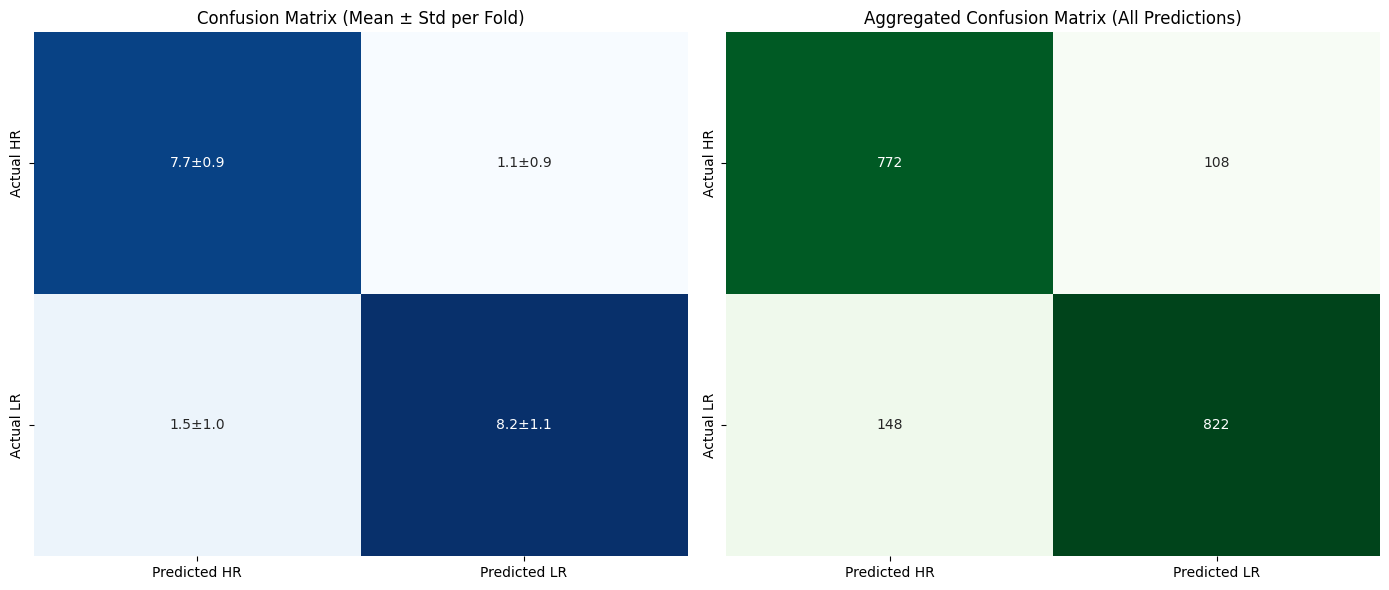

Side-by-side confusion matrices saved as 'confusion_matrices_side_by_side.png'


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----- Mean ± Std confusion matrix values -----
# cm_mean and cm_std are already available from previous execution

# Create annotation strings: mean ± std
annot_mean_std = np.array([
    [f"{cm_mean[0,0]:.1f}±{cm_std[0,0]:.1f}", f"{cm_mean[0,1]:.1f}±{cm_std[0,1]:.1f}"],
    [f"{cm_mean[1,0]:.1f}±{cm_std[1,0]:.1f}", f"{cm_mean[1,1]:.1f}±{cm_std[1,1]:.1f}"]
])

# ----- Aggregated confusion matrix -----
# cm_aggregated is already available from previous execution

# Create annotation strings for aggregated matrix
annot_agg = np.array([
    [f"{cm_aggregated[0,0]}", f"{cm_aggregated[0,1]}"],
    [f"{cm_aggregated[1,0]}", f"{cm_aggregated[1,1]}"]
])

# ----- Plot -----
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mean ± Std Confusion Matrix
sns.heatmap(
    cm_mean, # Use the mean values for the heatmap colors
    annot=annot_mean_std,
    fmt="", # Use empty format string to allow custom annotations
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted HR", "Predicted LR"],
    yticklabels=["Actual HR", "Actual LR"],
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Mean ± Std per Fold)", fontsize=12)

# Aggregated Confusion Matrix
sns.heatmap(
    cm_aggregated,
    annot=annot_agg,
    fmt="",
    cmap="Greens",
    cbar=False,
    xticklabels=["Predicted HR", "Predicted LR"],
    yticklabels=["Actual HR", "Actual LR"],
    ax=axes[1]
)
axes[1].set_title("Aggregated Confusion Matrix (All Predictions)", fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrices_side_by_side.png", dpi=300)
plt.show()

print("Side-by-side confusion matrices saved as 'confusion_matrices_side_by_side.png'")